<a href="https://colab.research.google.com/github/maxla777/Project-2/blob/Monique/Monique/ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning Models

In [3]:
csv_path = Path('/content/drive/MyDrive/Colab Notebooks/ETH_bull_bear_signals.csv')
df_crypto_news=pd.read_csv(csv_path)
df_crypto_news.set_index(pd.to_datetime(df_crypto_news['date'], infer_datetime_format=True), inplace=True)
df_crypto_news.drop(columns=['date'], inplace=True)
df_crypto_news.head()

,signal
date,
2020-12-01,1.0
2020-12-02,0.0
2020-12-03,0.0
2020-12-04,1.0
2020-12-05,0.0


In [4]:
df_crypto_news.tail()

,signal
date,
2021-03-17,0.0
2021-03-18,0.0
2021-03-19,0.0
2021-03-20,-1.0
2021-03-21,-1.0


In [5]:
csv_path = Path('/content/drive/MyDrive/Colab Notebooks/kraken_pull_EthExample_03202021.csv')
df_eth_returns=pd.read_csv(csv_path)
df_eth_returns.set_index(pd.to_datetime(df_eth_returns['Date'], infer_datetime_format=True), inplace=True)
df_eth_returns.drop(columns=['Date'], inplace=True)
df_eth_returns = df_eth_returns[['Positive Return']].copy()
df_eth_returns.head()

,Positive Return
Date,
2019-04-21,0.0
2019-04-22,1.0
2019-04-23,0.0
2019-04-24,0.0
2019-04-25,0.0


In [6]:
df_eth_returns.tail()

,Positive Return
Date,
2021-03-16,1.0
2021-03-17,1.0
2021-03-18,0.0
2021-03-19,1.0
2021-03-20,1.0


In [7]:
# Set x variable list of features
x_var_list = ['signal']

# Construct training start and end dates
training_start = df_crypto_news.index.min().strftime(format= '%Y-%m-%d')
training_end = '2021-02-15'

# Construct testing start and end dates
testing_start =  '2021-02-16'
testing_end = df_eth_returns.index.max().strftime(format= '%Y-%m-%d')

# Construct the X_train and y_train datasets
X_train = df_crypto_news[x_var_list][training_start:training_end]
y_train = df_eth_returns['Positive Return'][training_start:training_end]

# Construct the X test and y test datasets
X_test = df_crypto_news[x_var_list][testing_start:testing_end]
y_test = df_eth_returns['Positive Return'][testing_start:testing_end]

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2020-12-01
Training End: 2021-02-15
Testing Start: 2021-02-16
Testing End: 2021-03-20


In [8]:
from sklearn.preprocessing import StandardScaler
#Create the StandardScaler instance
scaler = StandardScaler()

In [9]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [10]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# AdaBoost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report, precision_recall_curve, roc_auc_score, hamming_loss, jaccard_score, matthews_corrcoef

In [12]:
# Fit a SKLearn linear regression using the training set (X_train, y_train):
AB_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1,
    random_state=0
)
AB_model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
AB_predictions = AB_model.predict(X_test)

# Assemble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = AB_predictions
Results

,Positive Return,Predicted Value
Date,,
2021-02-16,1.0,1.0
2021-02-17,1.0,1.0
2021-02-18,1.0,1.0
2021-02-19,1.0,0.0
2021-02-20,0.0,1.0
2021-02-21,1.0,1.0
2021-02-22,0.0,1.0
2021-02-23,0.0,1.0
2021-02-24,1.0,1.0


In [13]:
print(AB_model.get_params()) # looked at parameters and experimented with them to see if they made significant differences

{'algorithm': 'SAMME.R', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': 'deprecated', 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None

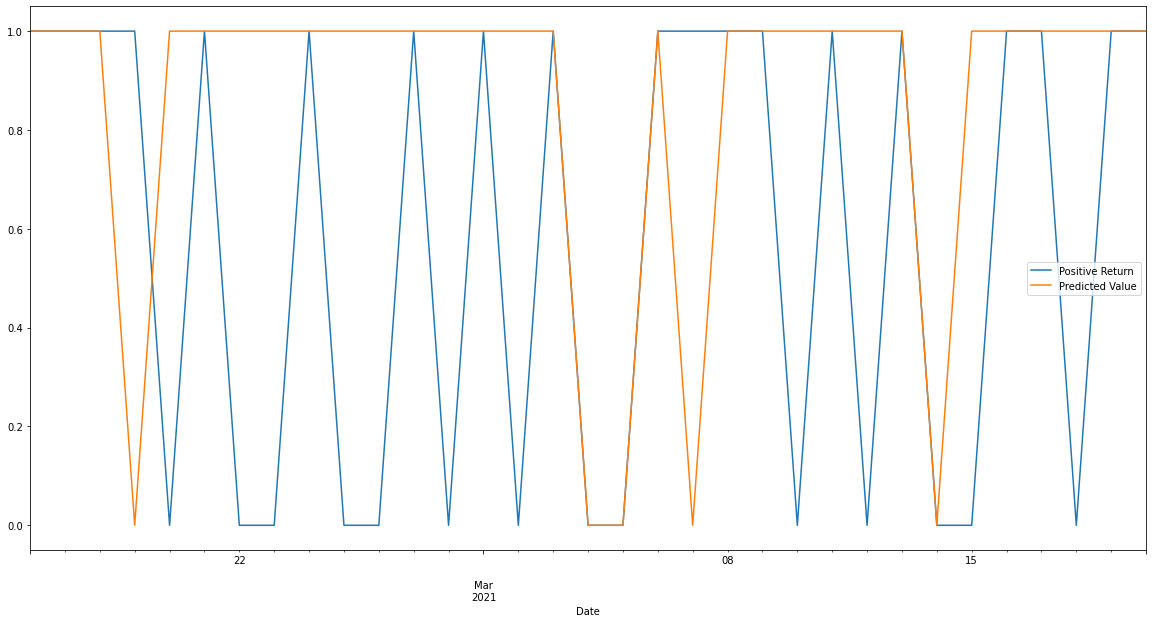

In [14]:
AB_Results = Results[['Positive Return','Predicted Value']]
AB_Results.plot(figsize=(20,10))

## Features

In [15]:
AB_importances = AB_model.feature_importances_

AB_importances_sorted = sorted(zip(AB_model.feature_importances_, df_crypto_news[x_var_list].columns), reverse=True)
AB_importances_sorted

[(0.17, 'signal')]

## Metrics

In [16]:
# Compute confusion matrix
AB_cm = confusion_matrix(y_test, AB_predictions)
# Create a DataFrame with the labelled classes
AB_cm_df = pd.DataFrame(
    AB_cm, index=['Actual Not Positive', 'Actual Positive'], columns=['Predicted Not Positive', 'Predicted Positive']
)
# Set target names for the classification report
AB_target_names = ['Not Positive', 'Positive']
# Compute the accuracy score
AB_acc_score = accuracy_score(y_test, AB_predictions)
# Compute the balanced accuracy score
AB_bal_acc_score = balanced_accuracy_score(y_test, AB_predictions)
# Predict class probabilities for the features 
AB_probs = AB_model.predict_proba(X_test)[:,1]
# Compute precision-recall pairs
AB_precision, AB_recall, _ = precision_recall_curve(y_test, AB_probs, pos_label=1)
# Compute the AUPRC - the area under the curve
AB_auprc_score = roc_auc_score(y_test, AB_probs)
# Compute the Matthews correlation coefficient (MCC)
AB_MCC_score = matthews_corrcoef(y_test, AB_predictions)
# Compute the Jaccard similarity coefficent score
AB_J_score = jaccard_score(y_test, AB_predictions)
# Compute the average Hamming loss
AB_H_loss = hamming_loss(y_test, AB_predictions)

Accuracy Score: 0.606
Balanced Accuracy Score: 0.555
Matthews correlation coefficient score: 0.15
Jaccard similarity coefficient score: 0.567
Average Hamming Loss: 0.394
Classification Report:
              precision    recall  f1-score   support

Not Positive       0.60      0.21      0.32        14
    Positive       0.61      0.89      0.72        19

    accuracy                           0.61        33
   macro avg       0.60      0.55      0.52        33
weighted avg       0.60      0.61      0.55        33

Confusion Matrix:


,Predicted Not Positive,Predicted Positive
Actual Not Positive,3,11
Actual Positive,2,17


Precision-Recall Curve
Area Under the Curve: 0.643


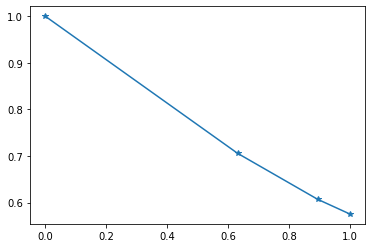

In [17]:
print("Accuracy Score:", round(AB_acc_score, ndigits=3))
print("Balanced Accuracy Score:", round(AB_bal_acc_score, ndigits=3))
print("Matthews correlation coefficient score:", round(AB_MCC_score, ndigits=3))
print("Jaccard similarity coefficient score:", round(AB_J_score, ndigits=3))
print("Average Hamming Loss:", round(AB_H_loss, ndigits=3))
print("Classification Report:")
print(classification_report(y_test, AB_predictions, target_names=AB_target_names))
print("Confusion Matrix:")
display(AB_cm_df)
print("Precision-Recall Curve")
print("Area Under the Curve:", round(AB_auprc_score, ndigits=3))
plt.plot(AB_recall, AB_precision, marker='*')

## Save Model

In [18]:
# Save the model once satisfied with results
# from joblib import dump, load
# dump(AB_model, 'AdaBoost_model.joblib') 

# Load saved model to use on other datasets
# AB_model = load('AdaBoost_model.joblib') 


# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [20]:
# Fit a SKLearn linear regression using just the training set (X_train, y_train):
RF_model = RandomForestClassifier(n_estimators=100, 
                               max_depth=1,
                               criterion='gini', # gini or entropy, gini is default
                               random_state=0)
RF_model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
RF_predictions = RF_model.predict(X_test)

# Assemble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = RF_predictions
Results

,Positive Return,Predicted Value
Date,,
2021-02-16,1.0,1.0
2021-02-17,1.0,1.0
2021-02-18,1.0,1.0
2021-02-19,1.0,0.0
2021-02-20,0.0,1.0
2021-02-21,1.0,1.0
2021-02-22,0.0,1.0
2021-02-23,0.0,1.0
2021-02-24,1.0,1.0


In [21]:
print(RF_model.get_params()) # looked at parameters and experimented with them to see if they made significant differences

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


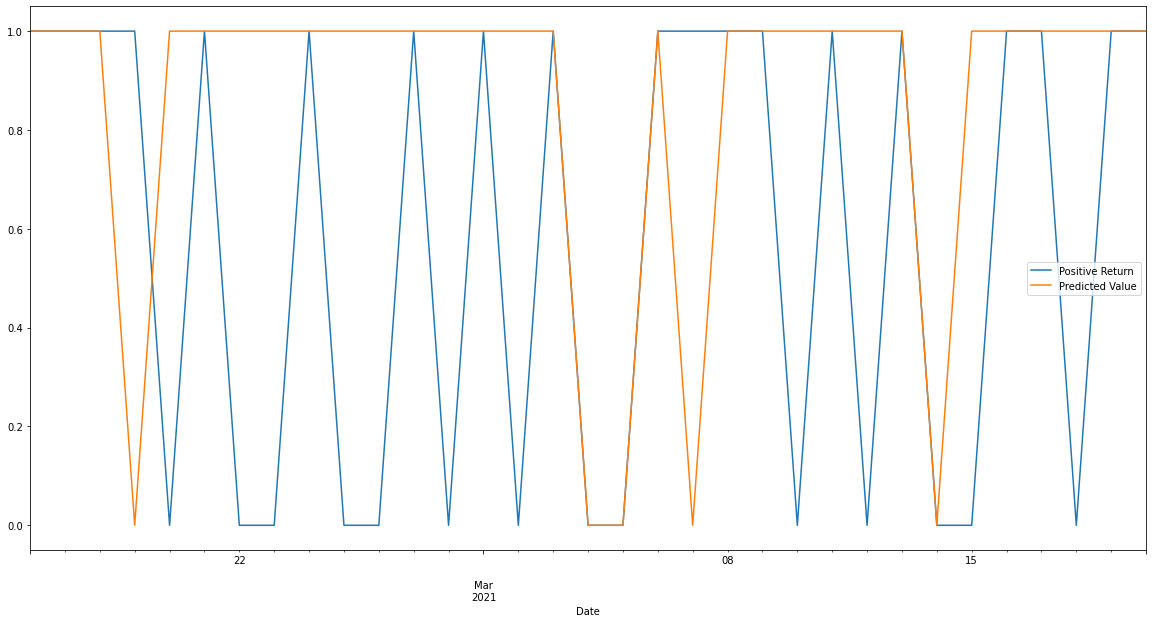

In [22]:
RF_Results = Results[['Positive Return','Predicted Value']]
RF_Results.plot(figsize=(20,10))

## Features

In [23]:
RF_importances = RF_model.feature_importances_

RF_importances_sorted = sorted(zip(RF_model.feature_importances_, df_crypto_news[x_var_list].columns), reverse=True)
RF_importances_sorted

[(1.0, 'signal')]

## Metrics

In [24]:
# Compute confusion matrix
RF_cm = confusion_matrix(y_test, RF_predictions)
# Create a DataFrame with the labelled classes
RF_cm_df = pd.DataFrame(
    RF_cm, index=['Actual Not Positive', 'Actual Positive'], columns=['Predicted Not Positive', 'Predicted Positive']
)
# Set target names for the classification report
RF_target_names = ['Not Positive', 'Positive']
# Compute the accuracy score
RF_acc_score = accuracy_score(y_test, RF_predictions)
# Compute the balanced accuracy score
RF_bal_acc_score = balanced_accuracy_score(y_test, RF_predictions)
# Predict class probabilities for the features 
RF_probs = RF_model.predict_proba(X_test)[:,1]
# Compute precision-recall pairs
RF_precision, RF_recall, _ = precision_recall_curve(y_test, RF_probs, pos_label=1)
# Compute the AUPRC - the area under the curve
RF_auprc_score = roc_auc_score(y_test, RF_probs)
# Compute the Matthews correlation coefficient (MCC)
RF_MCC_score = matthews_corrcoef(y_test, RF_predictions)
# Compute the Jaccard similarity coefficent score
RF_J_score = jaccard_score(y_test, RF_predictions)
# Compute the average Hamming loss
RF_H_loss = hamming_loss(y_test, RF_predictions)

Accuracy Score: 0.606
Balanced Accuracy Score: 0.555
Matthews correlation coefficient score: 0.15
Jaccard similarity coefficient score: 0.567
Average Hamming Loss: 0.394
Classification Report:
              precision    recall  f1-score   support

Not Positive       0.60      0.21      0.32        14
    Positive       0.61      0.89      0.72        19

    accuracy                           0.61        33
   macro avg       0.60      0.55      0.52        33
weighted avg       0.60      0.61      0.55        33

Confusion Matrix:


,Predicted Not Positive,Predicted Positive
Actual Not Positive,3,11
Actual Positive,2,17


Precision-Recall Curve
Area Under the Curve: 0.643


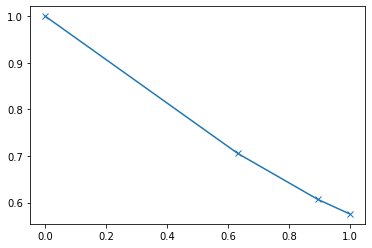

In [25]:
print("Accuracy Score:", round(RF_acc_score, ndigits=3))
print("Balanced Accuracy Score:", round(RF_bal_acc_score, ndigits=3))
print("Matthews correlation coefficient score:", round(RF_MCC_score, ndigits=3))
print("Jaccard similarity coefficient score:", round(RF_J_score, ndigits=3))
print("Average Hamming Loss:", round(RF_H_loss, ndigits=3))
print("Classification Report:")
print(classification_report(y_test, RF_predictions, target_names=RF_target_names))
print("Confusion Matrix:")
display(RF_cm_df)
print("Precision-Recall Curve")
print("Area Under the Curve:", round(RF_auprc_score, ndigits=3))
plt.plot(RF_recall, RF_precision, marker='x')

## Save Random Forest Model

In [26]:
# Save the model once satisfied with results
# from joblib import dump, load
# dump(RF_model, 'RandomForest_model.joblib') 

# Load saved model to use on other datasets
# RF_model = load('RandomForest_model.joblib') 
